# Conectar a base de datos y extraer tablas
AdventureWorks es una base de datos de ejemplo proporcionada por Microsoft, utilizada principalmente para demostraciones, pruebas y aprendizaje. Representa un entorno de datos ficticio pero realista basado en una empresa de fabricación y venta de bicicletas. La versión actual AdventureWorks2022, proporciona datos entre 2011-05-31 y 2014-06-30.

In [20]:
# Importar librerías
import pyodbc as pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Realizar la conexión con la base de datos
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=LAPTOP-KFKKDC80;"
    "DATABASE=AdventureWorks2022;"
    "Trusted_Connection=yes;"
)

In [22]:
conn

In [23]:
# Crear una función, la llamo "consulta" y dento pegaré la consulta SQL que necesite hacer en cada caso
def consulta(query):                       
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [i[0] for i in cursor.description]
    df = pd.DataFrame.from_records(
        rows,
        columns = columns
    )
    return df

In [24]:
# Consulta para traer la tabla de ventas
consulta = """
    SELECT 
    p.ProductID,
    p.Name AS Producto,
    soh.OrderDate AS Fecha_Venta,
    sod.OrderQty AS Cantidad_Vendida,
    soh.SalesOrderID,
    soh.CustomerID,
    soh.SalesPersonID,
    soh.Status AS Estado_Orden,
    pc.Name AS Categoria,
    sod.UnitPrice AS Precio_Unitario,
    (sod.OrderQty * sod.UnitPrice) AS Total_Venta
FROM Sales.SalesOrderDetail sod
JOIN Sales.SalesOrderHeader soh ON sod.SalesOrderID = soh.SalesOrderID
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
ORDER BY soh.OrderDate;
"""

In [25]:
# Cargar los datos en un DataFrame:
ventas = pd.read_sql(consulta, conn)

C:\Users\virgi\AppData\Local\Temp\ipykernel_21400\458380879.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ventas = pd.read_sql(consulta, conn)


In [26]:
ventas.head()

,ProductID,Producto,Fecha_Venta,Cantidad_Vendida,SalesOrderID,CustomerID,SalesPersonID,Estado_Orden,Categoria,Precio_Unitario,Total_Venta
0,776,"Mountain-100 Black, 42",2011-05-31,1,43659,29825,279.0,5,Bikes,2024.9940,2024.9940
1,741,"HL Mountain Frame - Silver, 48",2011-05-31,2,43661,29734,282.0,5,Components,818.7000,1637.4000
2,773,"Mountain-100 Silver, 44",2011-05-31,1,43665,29580,283.0,5,Bikes,2039.9940,2039.9940
3,765,"Road-650 Black, 58",2011-05-31,6,43668,29614,282.0,5,Bikes,419.4589,2516.7534
4,777,"Mountain-100 Black, 44",2011-05-31,3,43659,29825,279.0,5,Bikes,2024.9940,6074.9820


In [27]:
ventas.Fecha_Venta.max()

Timestamp('2014-06-30 00:00:00')

In [28]:
# ventas.to_excel("ventas.xlsx", index=False)

In [29]:
# Consulta SQL para extraer datos del inventario
consulta = """
SELECT 
    p.ProductID,
    p.Name AS Producto,
    pc.Name AS Categoria,
    pi.LocationID,
    pi.Quantity AS Stock_Disponible
FROM Production.Product p
JOIN Production.ProductInventory pi ON p.ProductID = pi.ProductID
JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
"""

In [30]:
# Cargar los datos en un DataFrame:
inventario = pd.read_sql(consulta, conn)

C:\Users\virgi\AppData\Local\Temp\ipykernel_21400\722142672.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inventario = pd.read_sql(consulta, conn)


In [31]:
# inventario.to_excel("inventario.xlsx", index=False)

In [32]:
inventario.head()

,ProductID,Producto,Categoria,LocationID,Stock_Disponible
0,707,"Sport-100 Helmet, Red",Accessories,7,288
1,708,"Sport-100 Helmet, Black",Accessories,7,324
2,709,"Mountain Bike Socks, M",Clothing,7,180
3,710,"Mountain Bike Socks, L",Clothing,7,216
4,711,"Sport-100 Helmet, Blue",Accessories,7,216


In [33]:
len(inventario)

460

In [34]:
inventario["ProductID"].nunique()

223

In [35]:
inventario_agrupado = inventario.groupby(["ProductID", "Producto", "Categoria"]).agg({
    "Stock_Disponible": "sum"
}).reset_index()
inventario_agrupado

,ProductID,Producto,Categoria,Stock_Disponible
0,707,"Sport-100 Helmet, Red",Accessories,288
1,708,"Sport-100 Helmet, Black",Accessories,324
2,709,"Mountain Bike Socks, M",Clothing,180
3,710,"Mountain Bike Socks, L",Clothing,216
4,711,"Sport-100 Helmet, Blue",Accessories,216
...,...,...,...,...
218,995,ML Bottom Bracket,Components,816
219,996,HL Bottom Bracket,Components,970
220,997,"Road-750 Black, 44",Bikes,153
221,998,"Road-750 Black, 48",Bikes,155


# Preparar DataFrame
Para realizar el análisis buscamos disponer de los datos de inventario actuales (2014) y una referencia de las ventas del año anterior (2013). 

In [37]:
# Extraer el año de cada venta:
ventas["Year"] = ventas["Fecha_Venta"].dt.year
ventas.head()

,ProductID,Producto,Fecha_Venta,Cantidad_Vendida,SalesOrderID,CustomerID,SalesPersonID,Estado_Orden,Categoria,Precio_Unitario,Total_Venta,Year
0,776,"Mountain-100 Black, 42",2011-05-31,1,43659,29825,279.0,5,Bikes,2024.9940,2024.9940,2011
1,741,"HL Mountain Frame - Silver, 48",2011-05-31,2,43661,29734,282.0,5,Components,818.7000,1637.4000,2011
2,773,"Mountain-100 Silver, 44",2011-05-31,1,43665,29580,283.0,5,Bikes,2039.9940,2039.9940,2011
3,765,"Road-650 Black, 58",2011-05-31,6,43668,29614,282.0,5,Bikes,419.4589,2516.7534,2011
4,777,"Mountain-100 Black, 44",2011-05-31,3,43659,29825,279.0,5,Bikes,2024.9940,6074.9820,2011


In [38]:
# Agrupar las ventas por referencia y año:
ventas_agrupada = ventas.groupby(["ProductID", "Year"]).agg({
    "Cantidad_Vendida": "sum"
}).reset_index()
ventas_agrupada

,ProductID,Year,Cantidad_Vendida
0,707,2011,331
1,707,2012,1278
2,707,2013,2940
3,707,2014,1717
4,708,2011,341
...,...,...,...
605,997,2014,267
606,998,2013,976
607,998,2014,580
608,999,2013,826


In [39]:
# Seleccionar las ventas de 2013:
ventas_2013 = ventas_agrupada[ventas_agrupada["Year"] == 2013].reset_index()
ventas_2013

,index,ProductID,Year,Cantidad_Vendida
0,2,707,2013,2940
1,6,708,2013,3088
2,14,711,2013,3088
3,18,712,2013,3768
4,20,713,2013,189
...,...,...,...,...
233,600,994,2013,253
234,602,996,2013,374
235,604,997,2013,389
236,606,998,2013,976


In [40]:
# Insertar el dato de ventas 2013 en la tabla de inventario:
df = inventario_agrupado.merge(
    ventas_2013[["ProductID", "Cantidad_Vendida"]].rename(columns={"Cantidad_Vendida": "Ventas2013"}), 
    on="ProductID", 
    how="left"
)
df.head()

,ProductID,Producto,Categoria,Stock_Disponible,Ventas2013
0,707,"Sport-100 Helmet, Red",Accessories,288,2940.0
1,708,"Sport-100 Helmet, Black",Accessories,324,3088.0
2,709,"Mountain Bike Socks, M",Clothing,180,NaN
3,710,"Mountain Bike Socks, L",Clothing,216,NaN
4,711,"Sport-100 Helmet, Blue",Accessories,216,3088.0


In [41]:
len(df)

223

# Análisis exploratorio

## Tratamiento de nulos

In [44]:
df.isnull().sum()/len(df) * 100

ProductID            0.000000
Producto             0.000000
Categoria            0.000000
Stock_Disponible     0.000000
Ventas2013          15.695067
dtype: float64

In [45]:
# 15% de nulos en cantidad vendida, lo que signica que el 15% de los artículos que están en el almacén NO se vendieron en 2013

In [46]:
# Reemplazar valores nulos por 0:
df["Ventas2013"] = df["Ventas2013"].fillna(0)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProductID         223 non-null    int64  
 1   Producto          223 non-null    object 
 2   Categoria         223 non-null    object 
 3   Stock_Disponible  223 non-null    int64  
 4   Ventas2013        223 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.8+ KB


## Análisis de referencias

In [49]:
# Número de referencias únicas
df.Producto.nunique()

223

In [50]:
# Número de Categorías únicas
df.Categoria.nunique()

4

In [51]:
df.groupby("Categoria")["Producto"].count()

Categoria
Accessories    29
Bikes          97
Clothing       35
Components     62
Name: Producto, dtype: int64

In [52]:
# Número de ubicaciones únicas
inventario.LocationID.nunique()

11

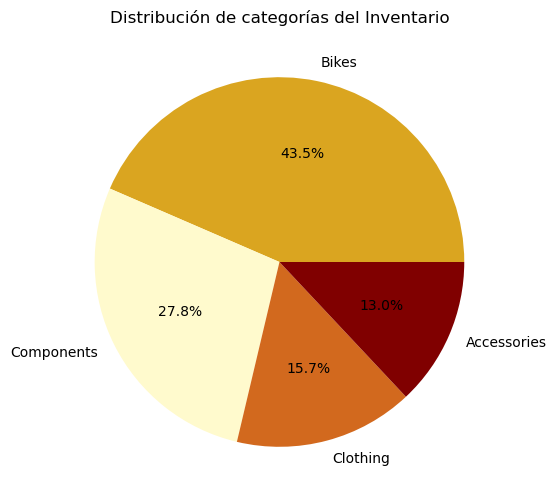

In [53]:
plt.figure(figsize=(6,6))
df["Categoria"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["goldenrod", "lemonchiffon", "chocolate", "maroon"])
plt.title("Distribución de categorías del Inventario")
plt.ylabel("")
plt.show()

In [54]:
# En el almacén tenemos 223 referencias, de 4 categorías de productos, distribuidas en 11 ubicaciones.

In [55]:
ubicaciones = inventario.groupby("LocationID").agg({
    "Producto": "count"
}).reset_index()
ubicaciones

,LocationID,Producto
0,1,19
1,5,16
2,6,41
3,7,151
4,10,19
5,20,15
6,30,7
7,40,4
8,45,3
9,50,72


## Análisis de stock

In [57]:
df.Stock_Disponible.sum()

77818

In [58]:
stock = df.groupby("Categoria")["Stock_Disponible"].sum().reset_index()

In [59]:
stock

,Categoria,Stock_Disponible
0,Accessories,9128
1,Bikes,15536
2,Clothing,5940
3,Components,47214


C:\Users\virgi\AppData\Local\Temp\ipykernel_21400\407393702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


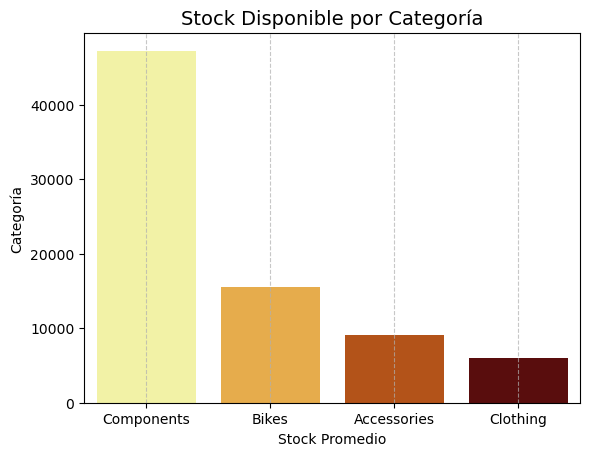

In [60]:
stock = stock.sort_values(by="Stock_Disponible", ascending=False)
sns.barplot(
    data = stock,
    x = "Categoria",
    y = "Stock_Disponible",
    palette="afmhot_r"
)

plt.title("Stock Disponible por Categoría", fontsize=14)
plt.xlabel("Stock Promedio")
plt.ylabel("Categoría")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

# Rotación de stock
La rotación de stock es un indicador que mide la eficiencia con la que una empresa gestiona su inventario. Se refiere a la cantidad de veces que el inventario de un producto se vende y se repone en un periodo determinado, generalmente un año.

Se calcula dividiendo las ventas en un período dado, en este caso 1 año, entre el inventario. Un valor alto indica que los productos se venden rápidamente y el inventario se renueva con frecuencia, lo cual es positivo para la liquidez, pero puede haber riesgo de ruptura. Un valor bajo puede sugerir exceso de inventario o lentitud en las ventas.

Clasificación del Inventario:
* Obsoleto → Rotación = 0 
* Óptimo → Rotación entre 0.5 y 2
* Sobrestock → Rotación menor a 0.5
* Riesgo de Ruptura → Rotación mayor a 2 (6 meses)

In [62]:
df["Rotación"] = df["Ventas2013"] / (df["Stock_Disponible"] + 1) # con el +1 se evitan divisiones entre 0
df.head()

,ProductID,Producto,Categoria,Stock_Disponible,Ventas2013,Rotación
0,707,"Sport-100 Helmet, Red",Accessories,288,2940.0,10.173010
1,708,"Sport-100 Helmet, Black",Accessories,324,3088.0,9.501538
2,709,"Mountain Bike Socks, M",Clothing,180,0.0,0.000000
3,710,"Mountain Bike Socks, L",Clothing,216,0.0,0.000000
4,711,"Sport-100 Helmet, Blue",Accessories,216,3088.0,14.230415


In [63]:
# Clasificación del stock en función de la rotación
def clasificar_stock(rotacion):
    if rotacion == 0:
        return "Obsoleto"
    elif rotacion < 0.5:
        return "Sobrestock"
    elif rotacion < 2:
        return "Stock Óptimo"
    else:
        return "Riesgo de Ruptura"

df["Clasificación"] = df["Rotación"].apply(clasificar_stock)

# Revisar la distribución
df["Clasificación"].value_counts()

Clasificación
Riesgo de Ruptura    85
Stock Óptimo         62
Sobrestock           41
Obsoleto             35
Name: count, dtype: int64

In [64]:
# df.to_excel("rotacion.xlsx", index=False)

## Distribución de la rotación

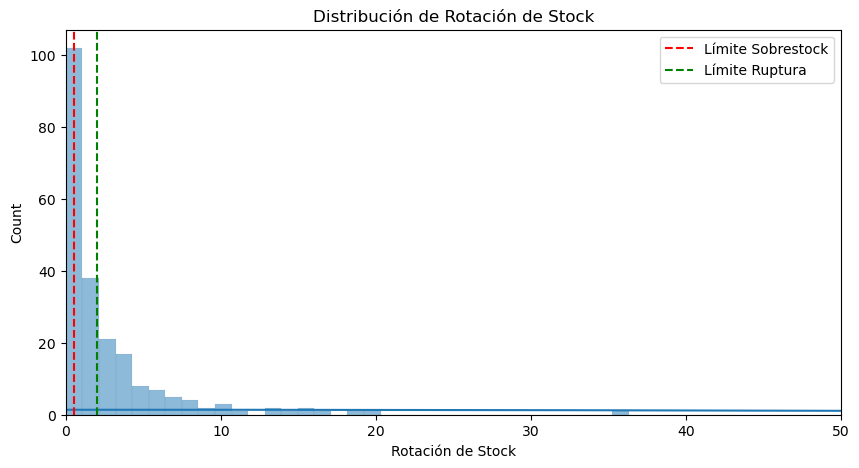

In [66]:
plt.figure(figsize=(10,5))
sns.histplot(df["Rotación"], bins=2000, kde=True)
plt.axvline(0.5, color="red", linestyle="--", label="Límite Sobrestock")
plt.axvline(2, color="green", linestyle="--", label="Límite Ruptura")
plt.title("Distribución de Rotación de Stock")
plt.xlabel("Rotación de Stock")
plt.xlim(0, 50)
plt.legend()
plt.show()

## Clasificación del inventario

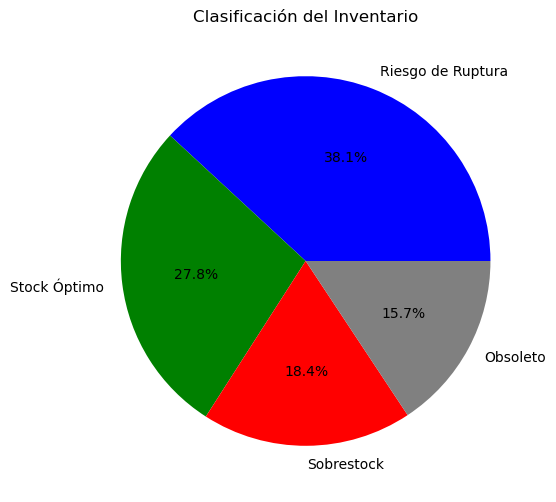

In [68]:
plt.figure(figsize=(6,6))
df["Clasificación"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["blue","green", "red", "grey"])
plt.title("Clasificación del Inventario")
plt.ylabel("")
plt.show()

## Referencias obsoletas

In [70]:
ref_sin_ventas = df[df["Rotación"] == 0].reset_index()
ref_sin_ventas

,index,ProductID,Producto,Categoria,Stock_Disponible,Ventas2013,Rotación,Clasificación
0,2,709,"Mountain Bike Socks, M",Clothing,180,0.0,0.0,Obsoleto
1,3,710,"Mountain Bike Socks, L",Clothing,216,0.0,0.0,Obsoleto
2,12,749,"Road-150 Red, 62",Bikes,133,0.0,0.0,Obsoleto
3,13,750,"Road-150 Red, 44",Bikes,223,0.0,0.0,Obsoleto
4,14,751,"Road-150 Red, 48",Bikes,140,0.0,0.0,Obsoleto
5,15,752,"Road-150 Red, 52",Bikes,128,0.0,0.0,Obsoleto
6,16,753,"Road-150 Red, 56",Bikes,163,0.0,0.0,Obsoleto
7,17,754,"Road-450 Red, 58",Bikes,148,0.0,0.0,Obsoleto
8,18,755,"Road-450 Red, 60",Bikes,137,0.0,0.0,Obsoleto
9,19,756,"Road-450 Red, 44",Bikes,129,0.0,0.0,Obsoleto


INSIGHT: Liquidar stock de estas 35 referencias.
* Descuentos y promociones agresivas:
    - Rebajas progresivas (ej. 30%, luego 50%, luego 70%) para incentivar compras rápidas.
    - Crear paquetes o combos con productos más vendidos.
    - Usar ofertas "2x1".
* Incentivos a clientes y programas de fidelización:
    - Regalar productos con compras superiores a cierto importe.
    - Usar puntos de fidelidad para que los clientes los canjeen por productos en stock.